In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns

from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier

from collections import Counter
from scipy.sparse import hstack

from sklearn.svm import SVC

from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV


import nltk
nltk.download('stopwords')

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported f

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
data = pd.read_csv('training_variants')

In [ ]:
data.head()

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [ ]:
data_text =pd.read_csv("training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)

In [ ]:
data_text.head()

,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


**Data Pre-processing**

In [ ]:
stop_words = set(stopwords.words('english'))


def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        # replace every special char with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
        # replace multiple spaces with single space
        total_text = re.sub('\s+',' ', total_text)
        # converting all the chars into lower-case.
        total_text = total_text.lower()
        
        for word in total_text.split():
        # if the word is a not a stop word then retain that word from the data
            if not word in stop_words:
                string += word + " "
        
        data_text[column][index] = string

In [ ]:
start_time = time.clock()
for index, row in data_text.iterrows():
    if type(row['TEXT']) is str:
        nlp_preprocessing(row['TEXT'], index, 'TEXT')
    else:
        print("there is no text description for id:",index)
print('Time took for preprocessing the text :',time.clock() - start_time, "seconds")

there is no text description for id: 1109
there is no text description for id: 1277
there is no text description for id: 1407
there is no text description for id: 1639
there is no text description for id: 2755
Time took for preprocessing the text : 28.827388 seconds


In [ ]:
#merging both gene_variations and text data based on ID
result = pd.merge(data, data_text,on='ID', how='left')
result.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [ ]:
result.loc[result['TEXT'].isnull(),'TEXT'] = result['Gene'] +' '+result['Variation']

In [ ]:
result['Text-final'] = result['TEXT']+ " " +result['Gene']+ " "+result['Variation']

In [ ]:
result.head()

,ID,Gene,Variation,Class,TEXT,Text-final
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...,oncogenic mutations monomeric casitas b lineag...


In [ ]:
result.shape

(3321, 6)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(result['Text-final'].values,result['Class'], test_size=0.3,shuffle=False,random_state=0)

In [ ]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in x_train:
    list_of_sentance.append(sentance.split())

In [ ]:
import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [ ]:
from tqdm import tqdm

**average word 2 vec model**

In [ ]:
w2v_model=gensim.models.Word2Vec(list_of_sentance,min_count=5,size=200)
w2v_words = list(w2v_model.wv.vocab)

In [ ]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = [];
for sent in tqdm(list_of_sentance):
    sent_vec = np.zeros(200)
    cnt_words =0;
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 2324/2324 [38:12<00:00,  1.01it/s]

2324
200


In [ ]:
from sklearn.manifold import TSNE 
import numpy as np
import seaborn as sn

**T-sne Model**

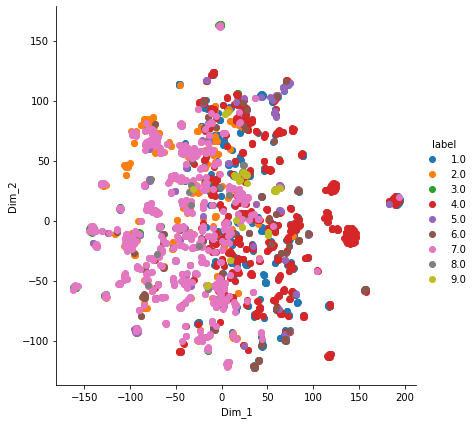

In [ ]:
labels=y_train
model = TSNE(n_components=2, random_state=0, perplexity=10, n_iter=5000) 
tsne_data = model.fit_transform(sent_vectors)
tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label")) 
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend() 
plt.show();

In [ ]:
i=0
list_of_sent_test=[]
for sent in x_test:
    list_of_sent_test.append(sent.split())

In [ ]:
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent_test): # for each review/sentence
    sent_vec = np.zeros(200) 
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

100%|██████████| 997/997 [24:39<00:00,  1.48s/it]

997
200


**Support vector machine with linear kernel**

In [ ]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV, train_test_split




clf = SGDClassifier(loss='hinge', max_iter=100)
calibrated_clf = CalibratedClassifierCV(base_estimator=clf, method='sigmoid', cv=3) 


grid_params = {'base_estimator__alpha': [0.0001,0.001,0.01,0.1,1,10,100,1000,10000]}  # note 'base_estimator__' in the params because you want to change params in the SGDClassifier
grid_search = GridSearchCV(estimator=calibrated_clf, param_grid=grid_params, cv=3)
grid_search.fit(sent_vectors, y_train)
print("Best HyperParameter: ",grid_search.best_params_)
print(grid_search.best_params_)

Best HyperParameter:  {'base_estimator__alpha': 0.1}
{'base_estimator__alpha': 0.1}


In [ ]:
sgd = SGDClassifier(loss='hinge',alpha=0.1,penalty='l2')
clf = CalibratedClassifierCV(sgd)
clf.fit(sent_vectors, y_train)
predict = clf.predict_proba(sent_vectors)
loss = log_loss(y_train, predict, labels=clf.classes_, eps=1e-15)
predict_y = clf.predict_proba(sent_vectors_test)
loss_test = log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15)
print("Train log loss :" ,loss)
print("Test log loss :" ,loss_test)

Train log loss : 1.3030297089333114
Test log loss : 1.6863570367384582


**function plots the confusion matrices**

In [ ]:

def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
    labels = [1,2,3,4,5,6,7,8,9]
    
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

In [ ]:
predicted_y = clf.predict(sent_vectors_test)

-------------------- Confusion matrix --------------------


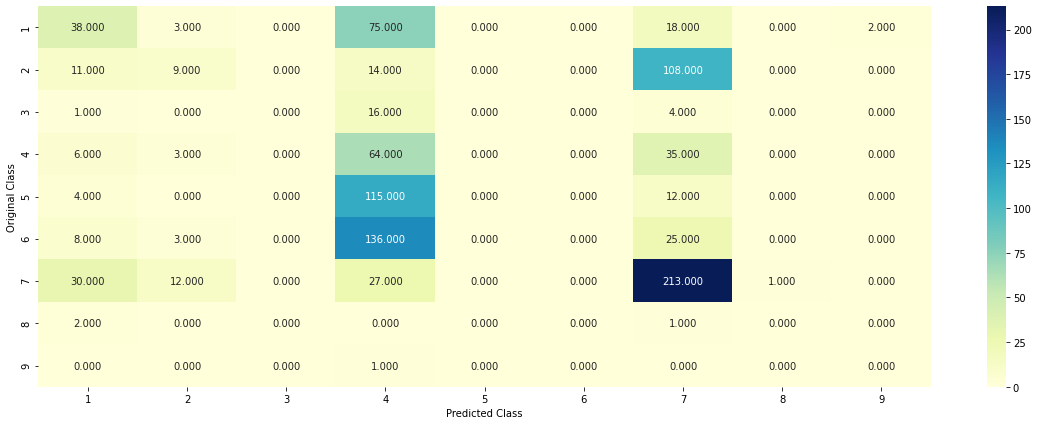

-------------------- Precision matrix (Columm Sum=1) --------------------


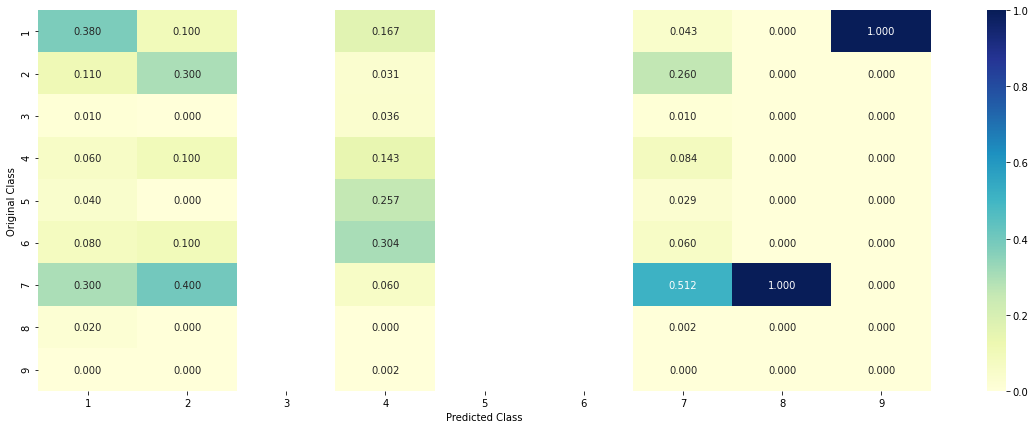

-------------------- Recall matrix (Row sum=1) --------------------


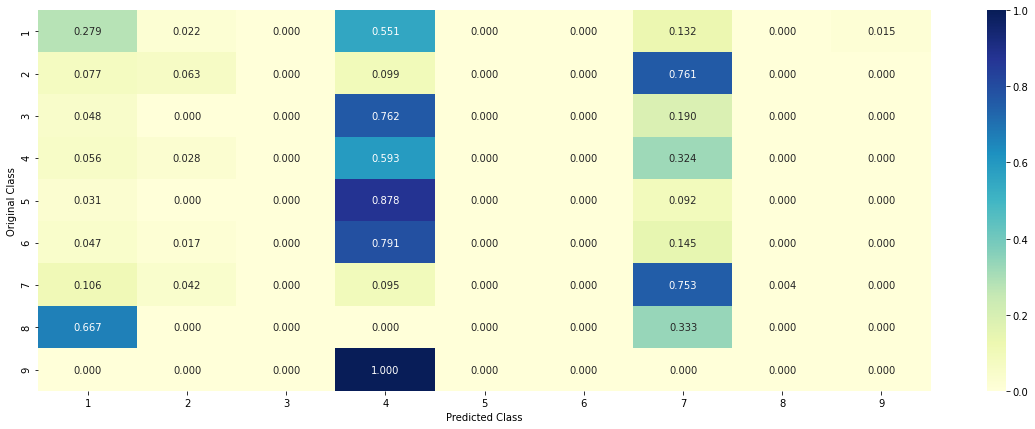

In [ ]:
plot_confusion_matrix(y_test, predicted_y)

**Support vector machine with RBF kernel**

In [ ]:
from sklearn.svm import SVC 

param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}  
  
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3) 

grid.fit(sent_vectors, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.288, total=   2.5s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s remaining:    0.0s


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.286, total=   2.5s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.9s remaining:    0.0s


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.288, total=   2.5s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.295, total=   2.5s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.289, total=   2.5s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.449, total=   1.7s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.490, total=   1.7s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.417, total=   1.7s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.469, total=   1.7s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] .

[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:  3.4min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [ ]:
print(grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_)

{'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


In [ ]:
model = SVC(C=10,kernel='rbf',probability=True)
model.fit(sent_vectors, y_train)
predict = model.predict_proba(sent_vectors)
loss = log_loss(y_train, predict, labels=model.classes_, eps=1e-15)
predict_y = model.predict_proba(sent_vectors_test)
loss_test = log_loss(y_test, predict_y, labels=model.classes_, eps=1e-15)
print("Train log loss :" ,loss)
print("Test log loss :" ,loss_test)

Train log loss : 0.6971636572685642
Test log loss : 1.6241282175686396


In [ ]:
predicted_y = model.predict(sent_vectors_test)

-------------------- Confusion matrix --------------------


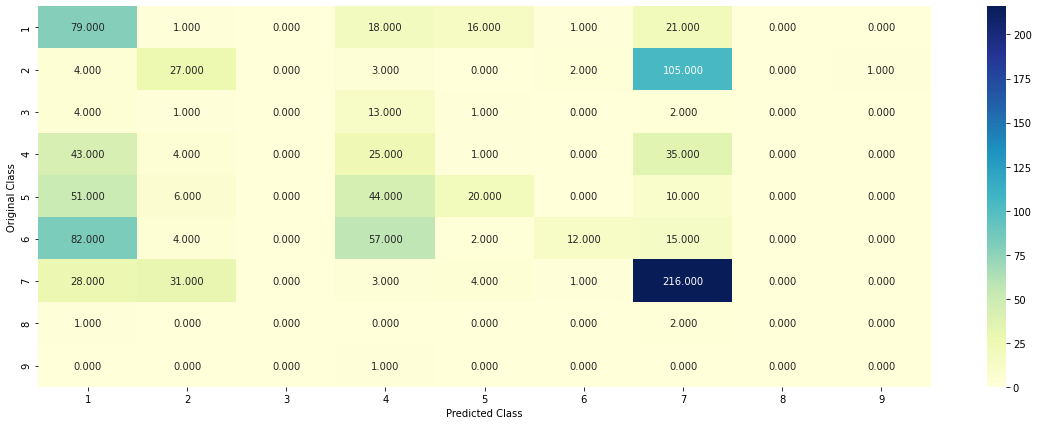

-------------------- Precision matrix (Columm Sum=1) --------------------


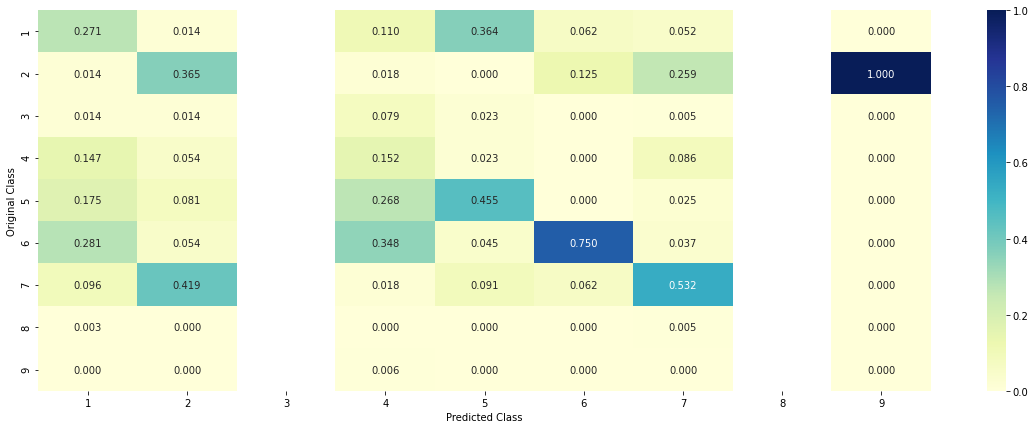

-------------------- Recall matrix (Row sum=1) --------------------


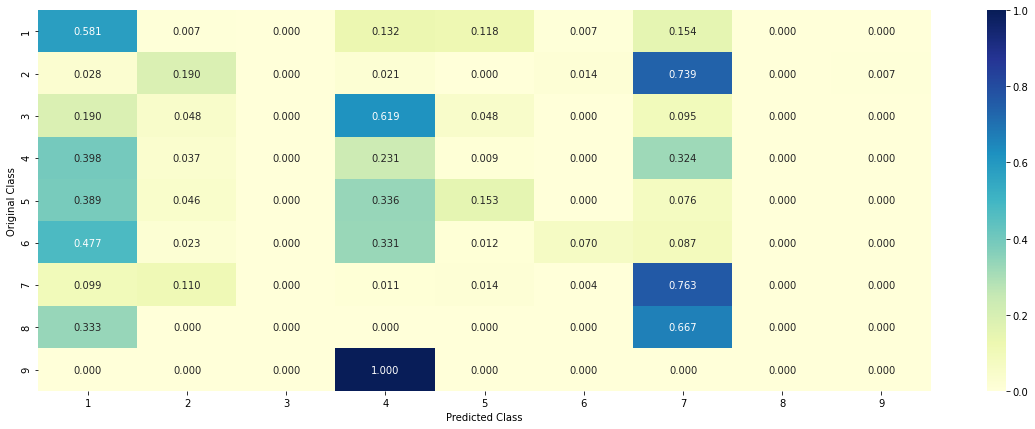

In [ ]:
plot_confusion_matrix(y_test, predicted_y)

**TF-IDF**

In [ ]:
y_true = result['Class'].values
result.Gene      = result.Gene.str.replace('\s+', '_')
result.Variation = result.Variation.str.replace('\s+', '_')

# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, test_df, Y_train, Y_test = train_test_split(result, y_true, stratify=y_true, test_size=0.2)

In [ ]:
train_variation=X_train['Variation'].values;test_variation=test_df['Variation'].values
train_gene=X_train['Gene'].values;test_gene=test_df['Gene'].values
train_text=X_train['TEXT'].values;test_text=test_df['TEXT'].values

from sklearn.feature_extraction.text import CountVectorizer
encode=CountVectorizer()
train_variation=encode.fit_transform(train_variation);test_variation=encode.transform(test_variation)
train_gene=encode.fit_transform(train_gene);test_gene=encode.transform(test_gene)

In [ ]:
train_text=encode.fit_transform(train_text);test_text=encode.transform(test_text)
print(train_text.shape)

(2656, 141164)


**one-hot encoding on Gene feature**

In [ ]:
gene_vectorizer = TfidfVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(X_train['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(test_df['Gene'])

**one-hot encoding on Variation Feature**

In [ ]:
variation_vectorizer = TfidfVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(X_train['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(test_df['Variation'])

In [ ]:
text_vectorizer = TfidfVectorizer(min_df=1,max_features=10000)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(X_train['TEXT'])
test_text_feature_onehotCoding = text_vectorizer.fit_transform(test_df['TEXT'])
train_text_features= text_vectorizer.get_feature_names()
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))
print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 10000


**Data Normalization**

In [ ]:

train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)


test_text_feature_onehotCoding = text_vectorizer.transform(test_df['TEXT'])

test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

**Satcking All feature together using Hstack()**

In [ ]:
train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))

In [ ]:
train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(X_train['Class']))

In [ ]:
test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(test_df['Class']))

In [ ]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2656, 12671)
(number of data points * number of features) in test data =  (665, 12671)


**Naive Bayes Model**

In [ ]:
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x_onehotCoding)
    cv_log_error_array.append(log_loss(test_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(test_y, sig_clf_probs))

for alpha = 1e-05
Log Loss : 1.8022442918932207
for alpha = 0.0001
Log Loss : 1.7860380575318933
for alpha = 0.001
Log Loss : 1.7665358678743213
for alpha = 0.1
Log Loss : 1.8948325967507538
for alpha = 1
Log Loss : 1.7840980027400613
for alpha = 10
Log Loss : 1.5513365442629263
for alpha = 100
Log Loss : 1.5008277181146805
for alpha = 1000
Log Loss : 1.4791014368903084


In [ ]:
best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)


predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(Y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  1000 The train log loss is: 1.1316158177561197
For values of best alpha =  1000 The test log loss is: 1.4791014368903084


In [ ]:
predicted_y_nv = sig_clf.predict(test_x_onehotCoding)

-------------------- Confusion matrix --------------------


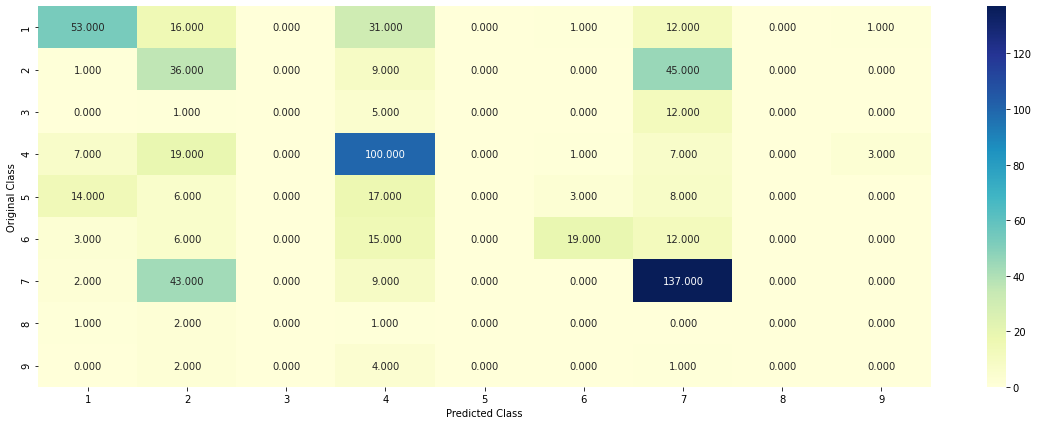

-------------------- Precision matrix (Columm Sum=1) --------------------


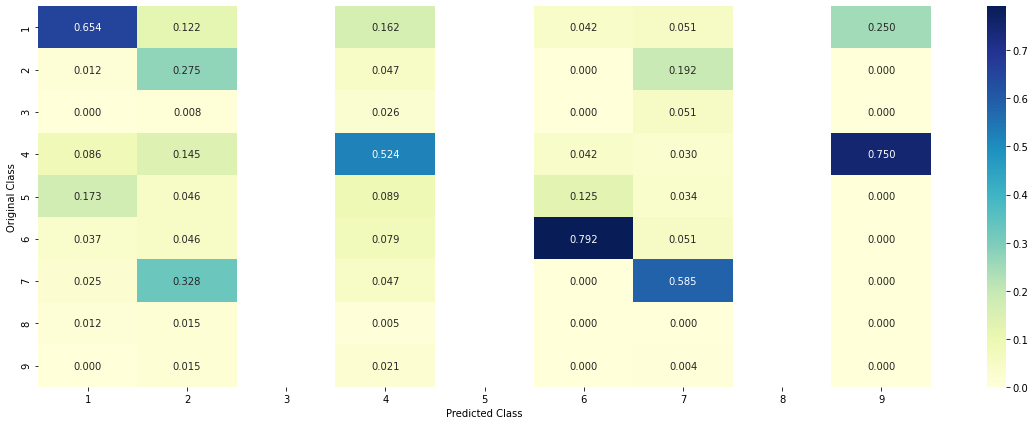

-------------------- Recall matrix (Row sum=1) --------------------


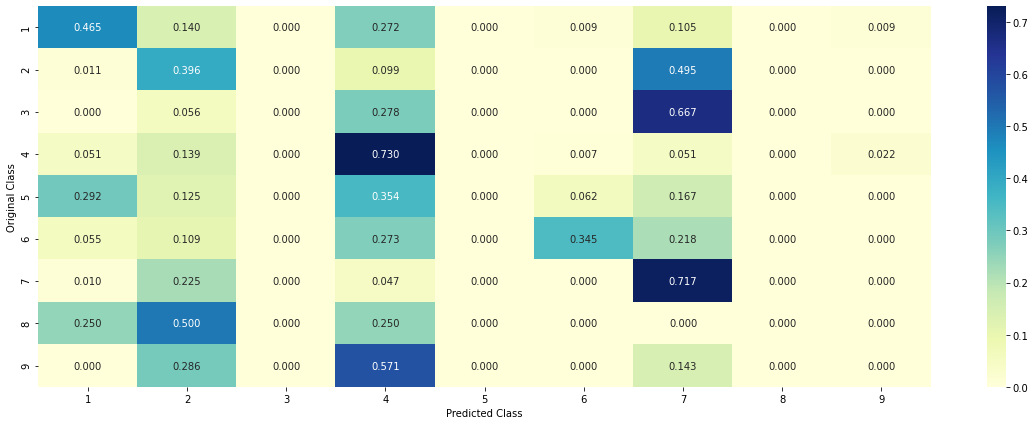

In [ ]:
plot_confusion_matrix(Y_test, predicted_y_nv)